# Loading Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import zipfile
import os, os.path

In [ ]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Defining path to access each class folder
Path = '/content/drive/My Drive/Raw_Data' ## put the Raw_Data folder in your Drive
subdir_list = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

#Function to count the number of images
def count_images(directory):
    return len([name for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name)) and
                name.lower().endswith(('.png', '.jpg', '.jpeg'))])

#Loop through each class, print number of images and total number of images
tot_images = 0
for subfolder in subdir_list:
    subfolder_path = os.path.join(Path, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = count_images(subfolder_path)
        tot_images += num_images
        print(f"Number of images in '{subfolder}': {num_images}")
print(f"Total number of images: {tot_images}")

Number of images in 'glioma_tumor': 2547
Number of images in 'meningioma_tumor': 2582
Number of images in 'no_tumor': 2500
Number of images in 'pituitary_tumor': 2658
Total number of images: 10287


The distribution of images in each class is fairly even/uniform; with each class containing between ~2400 - ~2650 images each. A fairly even class distribution will prevent the model from unfairly "memorizing/predicting" one class.

# Data Splitting

Using splitfolders which will split (via random sampling) a folder containing data into a test,validation and training dataset. The team will be using a 60-20-20 %, training - validation - test split.

In [ ]:
!pip install split_folders

In [ ]:
import splitfolders
num_workers = 4
splitfolders.ratio(Path, '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split',seed=999, ratio=(.6,.2,.2), workers = num_workers)

Copying files: 10287 files [2:00:21,  1.42 files/s]


In [ ]:
split_list = ['train', 'val', 'test']
subdir_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split'

tot_images = 0
for split in split_list:
    split_path = os.path.join(subdir_path, split)
    if os.path.isdir(split_path):
        print(f"{split} set image distribution:")
        for class_folder in subdir_list:
            class_folder_path = os.path.join(split_path, class_folder)
            if os.path.isdir(class_folder_path):
                num_images = count_images(class_folder_path)
                tot_images += num_images
                print(f"  Number of images in class '{class_folder}': {num_images}")
print(f"Total number of images: {tot_images}")

train set image distribution:
  Number of images in class 'glioma_tumor': 1528
  Number of images in class 'meningioma_tumor': 1549
  Number of images in class 'no_tumor': 1500
  Number of images in class 'pituitary_tumor': 1594
val set image distribution:
  Number of images in class 'glioma_tumor': 509
  Number of images in class 'meningioma_tumor': 516
  Number of images in class 'no_tumor': 500
  Number of images in class 'pituitary_tumor': 531
test set image distribution:
  Number of images in class 'glioma_tumor': 510
  Number of images in class 'meningioma_tumor': 517
  Number of images in class 'no_tumor': 500
  Number of images in class 'pituitary_tumor': 533
Total number of images: 10287


# Data Cleaning and Augmentation

Cleaning - transforming images into tensors, resizing them into 224 by 224 and Normalizing.

Augmentation - applying random rotations, adding noise and changing color intensity

#### Looking at an example image first

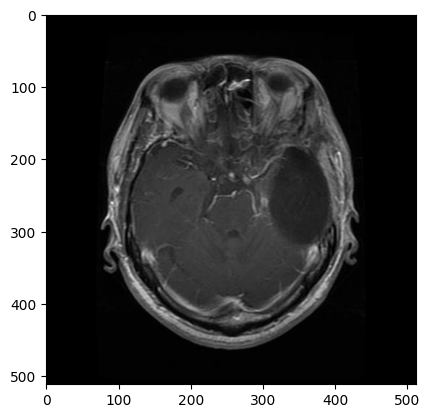

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import urllib

# loading an image
path = "/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/test/glioma_tumor/Te-gl_0015.jpg"
img = plt.imread(path)
plt.imshow(img)

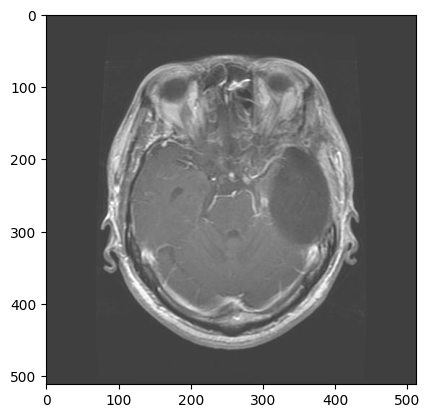

In [ ]:
# applying a discoloring effect
img = img/255
img_changed = np.clip((img + 0.25), 0, 1)
plt.imshow(img_changed)

In [ ]:
import torch

#convert to tensor
x = torch.from_numpy(img)
print(x.shape)

# move the channel dimension to the beginning
x = x.permute(2,0,1)
print(x.shape)

torch.Size([512, 512, 3])
torch.Size([3, 512, 512])


Therefore, each image has 3 color channels and has a size of 512 by 512 pixels. Each image also has color intensities ranging from 0 to 255.

#### Changing images to grayscale (1 color channel), 224 by 224 pixels, normalizing color intensities and applying augmentations


In [ ]:
# randomly changing color intensity in each image by a constant value

folder_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/train'

for Class in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
  class_path = os.path.join(folder_path, Class)

  # List contents of the folder
  contents = os.listdir(class_path)

  for img_name in contents:
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    random_num = np.random.randint(0,1)
    if(random_num < 0.5):
      img = img/255
      img = np.clip((img + 0.25), 0, 1)


In [ ]:
def create_loaders(batch_size):

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((150, 150)),
                                    transforms.Normalize((0.5), (0.5))
                                    ])

    augment = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((150, 150)),
                                    transforms.Normalize((0.5), (0.5)),
                                    transforms.RandomRotation(45),
                                    transforms.GaussianBlur(5, (0.1,2))
                                    ])



    #Create Datasets for each set and apply transformation to training dataset
    train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/train', transform=augment)
    val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/val', transform = transform)
    test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split/test', transform = transform)


    #Create DataLoaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

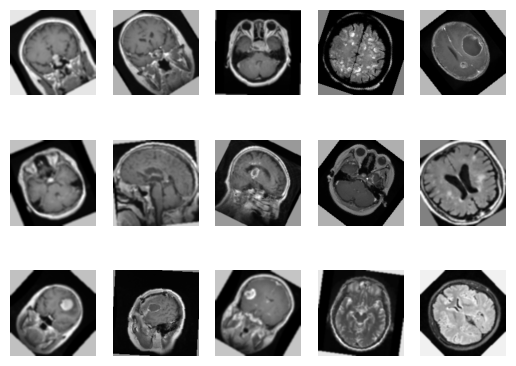

In [ ]:
BATCH = 32
LR = 0.001
EPOCH = 10

train_loader, val_loader, test_loader = create_loaders(BATCH)

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')

    k += 1
    if k > 14:
        break

In [ ]:
def train(net, train_loader, val_loader, batch = 64, learning_rate=0.001, num_epochs=10):

    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets

    torch.manual_seed(1000)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device_name), labels.to(device_name)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            temp, predicted = torch.max(outputs.data, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += labels.size(0)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device_name), labels.to(device_name)
        labels = labels.long()  # Ensure labels are torch.LongTensor
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
        total_loss += loss.item()
        total_epoch += labels.size(0)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel, self).__init__()
    self.name = "baseline"
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64 * 36 * 36, 512)
    self.fc2 = nn.Linear(512, 4)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 36 * 36)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model = BaselineModel()
model.to(device_name)
train(model, train_loader = train_loader, val_loader = val_loader, batch = BATCH, learning_rate = LR, num_epochs=EPOCH)

Epoch 1: Train err: 0.3859990277102577, Train loss: 1.0688137076988122 |Validation err: 0.2616731517509728, Validation loss: 0.6890531851695134
Epoch 2: Train err: 0.25830497488251497, Train loss: 0.665516426526203 |Validation err: 0.23151750972762647, Validation loss: 0.5981506778643682
Epoch 3: Train err: 0.22459893048128343, Train loss: 0.5783069411707665 |Validation err: 0.2169260700389105, Validation loss: 0.5744924866236173
Epoch 4: Train err: 0.19980554205153137, Train loss: 0.5171847341128581 |Validation err: 0.19066147859922178, Validation loss: 0.5129059656308248
Epoch 5: Train err: 0.18376276130286825, Train loss: 0.470438507013988 |Validation err: 0.1882295719844358, Validation loss: 0.4510593865926449
Epoch 6: Train err: 0.1711229946524064, Train loss: 0.4488053151208502 |Validation err: 0.20671206225680933, Validation loss: 0.533539475615208
Epoch 7: Train err: 0.16318262842327014, Train loss: 0.4236273006608449 |Validation err: 0.16926070038910507, Validation loss: 0.456

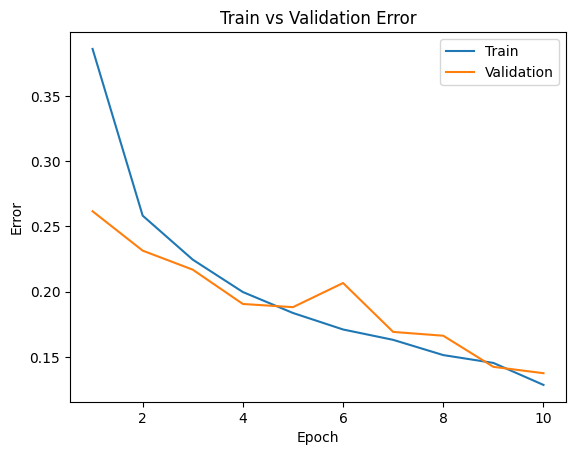

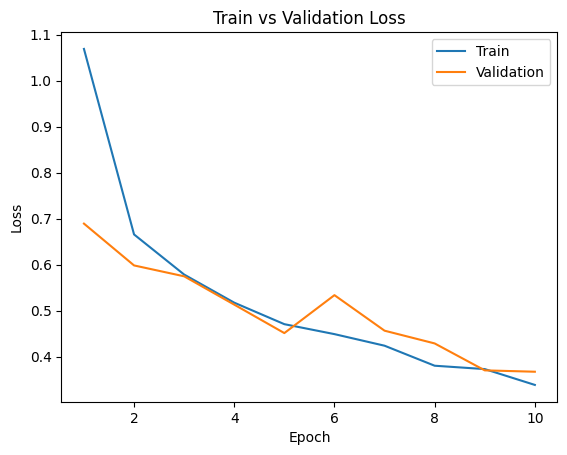

In [ ]:
plot_training_curve(get_model_name('baseline', BATCH, LR, EPOCH-1))

In [ ]:
criterion = nn.CrossEntropyLoss()

evaluate(model, test_loader, criterion)

(0.13349514563106796, 0.35880756550110304)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('glioma_tumor', 'meningioma_tumor', 'no_tumor','pituitary_tumor')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# Load pre-trained model and modify the final layer
from torchvision import models
model2 = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel instead of 3
model2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final layer to have 4 classes
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 4)  # 4 classes

def freeze_layers(model):
    layers = list(model.children())
    num_layers_to_freeze = len(layers) // 2

    for i in range(num_layers_to_freeze):
        for param in layers[i].parameters():
            param.requires_grad = False

In [ ]:

BATCH2 = 128
LR2 = 0.001
EPOCH2 = 15
train(model2, train_loader = train_loader, val_loader = val_loader, batch = BATCH2, learning_rate = LR2, num_epochs=EPOCH2)